# Domain Distribution Drift Analysis

### Necessary imports

In [ ]:
# imports and installs
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch.optim import SGD, Adam, ASGD

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import monai
from monai.transforms import (ScaleIntensityRange, Compose, AddChannel, RandSpatialCrop, ToTensor, 
                            RandAxisFlip, Activations, AsDiscrete, Resize, RandRotate, RandFlip, EnsureType,
                             KeepLargestConnectedComponent, CenterSpatialCrop)
from monai.metrics import DiceMetric, HausdorffDistanceMetric, PSNRMetric, SSIMMetric
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, FocalLoss, GeneralizedDiceLoss, DiceCELoss, DiceFocalLoss
from monai.networks.nets import UNet, VNet, UNETR, SwinUNETR, AttentionUnet, AutoEncoder
from monai.data import decollate_batch, ImageDataset
from monai.utils import set_determinism
import os
import wandb
from time import time
from einops import rearrange
from einops.layers.torch import Rearrange
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR
from random import sample

torch.manual_seed(2000)
set_determinism(seed=2000)

wandb_log = True

# !jupyter nbextension enable --py widgetsnbextension

In [ ]:
def get_img_label_folds(img_paths, label_paths):
    
    fold = list(range(0,len(img_paths)))
    fold = sample(fold, k=len(fold))
    fold_imgs = [img_paths[i] for i in fold]
    fold_labels = [label_paths[i] for i in fold]
    return fold_imgs, fold_labels

# Transforms for images & labels
train_roi_size = 160
resize_dim = 256
transforms_map = {
        "train_img_transform" : [
            AddChannel(),
            Resize(spatial_size=(resize_dim, resize_dim, -1)),
            # CenterSpatialCrop([train_roi_size, train_roi_size, -1]),
            # RandSpatialCrop(roi_size= train_roi_size, random_center = True, random_size=False),
            ToTensor()
            ],
        "train_label_transform" : [
            AddChannel(),
            # Resize(spatial_size=(resize_dim, resize_dim, -1)),
            # CenterSpatialCrop([train_roi_size, train_roi_size, -1]),
            # RandSpatialCrop(roi_size= train_roi_size, random_center = True, random_size=False),
            AsDiscrete(threshold=0.5),
            ToTensor()
            ],
        "test_img_transform" : [
            AddChannel(),
            # Resize(spatial_size=(resize_dim, resize_dim, -1)),
            CenterSpatialCrop([train_roi_size, train_roi_size, -1]),
            ToTensor()
            ],
        "test_label_transform" : [
            AddChannel(),
            # Resize(spatial_size=(resize_dim, resize_dim, -1)),
            # CenterSpatialCrop([train_roi_size, train_roi_size, -1]),
            AsDiscrete(threshold=0.5),
            ToTensor()
            ],
    }

# 1. Image & Label paths

dataset_map = {
        "promise12" : {
            "data_dir" : "../datasets/promise12prostatealigned/",
            "test_size" : 0.1,
            'test' :  {'images' : [], 'labels' : []},
            'train' :  {'images' : [], 'labels' : []}
            
            },
        "decathlon" : {
            "data_dir" : "../datasets/decathlonprostatealigned/",
            "test_size" : 0.2,
            'test' :  {'images' : [], 'labels' : []},
            'train' :  {'images' : [], 'labels' : []}
            },
        "isbi" : {
            "data_dir" : "../datasets/isbiprostatealigned/",
            "test_size" : 0.2,
            'test' :  {'images' : [], 'labels' : []},
            'train' :  {'images' : [], 'labels' : []}
            },
        "prostate158" : {
            "data_dir" : "../datasets/prostate158aligned/",
            "test_size" : 0.2,
            'test' :  {'images' : [], 'labels' : []},
            'train' :  {'images' : [], 'labels' : []}
            }
        
    }


for dataset in dataset_map:
    print(f"------------{dataset}------------")
    data_dir = dataset_map[dataset]['data_dir']

    img_paths = glob(data_dir + "imagesTr/*.nii")
    label_paths = glob(data_dir + "labelsTr/*.nii")
    img_paths.sort()
    label_paths.sort()
    
    # 2. Folds

    images_fold, labels_fold  = get_img_label_folds(img_paths, label_paths)
    
    print("Number of images: {}".format(len(images_fold)))
    print("Number of labels: {}".format(len(labels_fold)))
    
    # Get train and test sets
    # 3. Split into train - test
    train_idx = int(len(images_fold) * (1 - dataset_map[dataset]['test_size']))
    
    # Store train & test sets 
    
    dataset_map[dataset]['train']['images'] = images_fold[:train_idx]
    dataset_map[dataset]['train']['labels'] = labels_fold[:train_idx]
    
    dataset_map[dataset]['test']['images'] = images_fold[train_idx:]
    dataset_map[dataset]['test']['labels'] = labels_fold[train_idx:]

In [ ]:
batch_size = 1
def get_dataloader(img_paths : list, train : bool):
    
    if train:
        ttset = "train"
    else:
        ttset = "test"
        
    dataset = ImageDataset(img_paths,
                            transform=Compose(transforms_map[f'train_img_transform']))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return  dataloader

In [ ]:
dataloaders_map = {}

for dataset in dataset_map:
    print(f"------------{dataset}------------")
    dataloaders_map[dataset] = {}
    for ttset in ['train', 'test']:
        if ttset == 'train':
            train = True
        else:
            train = False
        
        dataloaders_map[dataset][ttset] = get_dataloader(img_paths = dataset_map[dataset][ttset]['images'],
                                                          train = train)
        
        print(f"""No of samples in {dataset}-{ttset} : {len(dataloaders_map[dataset][ttset])}""")

# 7. That's it

In [ ]:
all_train_img_paths = []
for dataset_name in dataset_map.keys():
    all_train_img_paths.extend(dataset_map[dataset_name]['train']['images'])
    
multi_domain_train_loader = get_dataloader(
    img_paths = all_train_img_paths, train=True
)

In [ ]:
# ----------------------------Get dataloaders--------------------------
imgs = next(iter(multi_domain_train_loader))
imgs = rearrange(imgs, 'b c h w d -> (b d) c h w')
print(f"\nImage shape : {imgs.shape}")

img_no = 10
plt.figure(figsize=(6*3,6*1))
# plt.subplot(1,3,1)
plt.imshow(imgs[img_no,0], cmap='gray')
plt.axis('off')
plt.title('Image')
plt.show()

In [ ]:
# print(f"\nTraining samples : {len(multi_domain_train_loader)}")

# # # -----------------------Slices-----------------------------

# plt.figure(figsize = (1*7, 1*7))

# # Spatial dims
# spdims = [img.shape[3] for img in multi_domain_train_loader]
# np.unique(spdims)
# print({x:spdims.count(x) for x in np.unique(spdims)})

# # # plt.subplot(1,2,1)
# plt.hist(spdims)
# plt.xlabel('Slices')
# plt.ylabel('Count')
# plt.title('Training Set')

# # # slices = [label.shape[4] for _, label in test_loader]
# # # plt.subplot(1,2,2)
# # # plt.hist(slices, )
# # # plt.xlabel('Slices')
# # # plt.ylabel('Count')
# # # plt.title('Testing set')

# # plt.suptitle('Slices in Training & Testing Sets')
# plt.show()

In [ ]:
class ClipToRange(monai.transforms.Transform):
    def __call__(self, x : torch.Tensor):
        return torch.clamp(x, min=0.0, max=1.0)

In [ ]:
# ----------------------------Train Config-----------------------------------------
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# model = AutoEncoder(
#     spatial_dims=2,
#     in_channels=1,
#     out_channels=1,
#     channels=(4, 8, 16, 32, 64),
#     strides=(2, 2, 2, 2, 2),
#     num_res_units = 3
# ).to(device)

model = UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

epochs = 100
initial_lr = 1e-3
optimizer = Adam(model.parameters(), lr=initial_lr, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=True)

mse_loss = torch.nn.MSELoss()
ssim_loss = monai.losses.ssim_loss.SSIMLoss()

ssim_metric = SSIMMetric(data_range = torch.Tensor([1.0]))
psnr_metric = PSNRMetric(max_val = 1.0, reduction='mean')

post_pred = Compose([
    ClipToRange()
    ])

In [ ]:
# x = torch.randn(10,1,20,20)
# y = torch.randn(10,1,20,20)
# data_range = x.max().unsqueeze(0)
# print(data_range)
# # the following line should print 1.0 (or 0.9999)
# print(ssim_loss(x,y,data_range))
# print(mse_loss(x,y))

In [ ]:
# ------------------------------------WANDB Logging-------------------------------------
config = {
    "Model" : "UNet",
    "Train Input ROI size" : train_roi_size,
    "Test mode" : f"Sliding window inference roi = {train_roi_size}",
    "Batch size" : "No of slices in original volume",
    "No of volumes per batch" : 1,
    "Epochs" : epochs,
    "Optimizer" : "Adam",
    "Scheduler" : "CosineAnnealingLR",
    "Initial LR" : scheduler.get_last_lr()[0],
    "Loss" : "MSELoss + 2*SSIMLoss", 
    "Train Data Augumentations" : "RandSpatialCrop",
    "Test Data Preprocess" : "None",
    "Train samples" : {"Promise12" : 45, "ISBI" : 63, "Decathlon" : 25, "Prostate158" : 111},
    "Test Samples" : {"Promise12" : 5, "ISBI" : 16, "Decathlon" : 7, "Prostate158" : 28},
    "Pred Post Processing" : "Clamping output to [0, 1]"
}
if wandb_log:
    wandb.login()
    wandb.init(project="DomainDistribution", entity="vinayu", config = config)

### Training function

In [ ]:
def train(train_loader : DataLoader):
    """
    Inputs : No Inputs
    Outputs : No Outputs
    Function : Trains all datasets and logs metrics to WANDB
    """
    
    train_start = time()
    epoch_loss = 0
    model.train()
    print('\n')
    
    
    # Iterating over the dataset
    for i, imgs in enumerate(train_loader, 1):

        imgs = imgs.to(device)
        imgs = rearrange(imgs, 'b c h w d -> (b d) c h w')

        optimizer.zero_grad()
        preds = model(imgs)

        loss = mse_loss(preds, imgs) + 2*ssim_loss(preds, imgs, data_range=imgs.max().unsqueeze(0))
        
        preds = post_pred(preds)
        # ssim(preds, imgs)
        psnr_metric(preds, imgs)
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if i % batch_interval == 0:
            print(f"Epoch: [{epoch}/{epochs}], Batch: [{i}/{len(train_loader)}], Loss: {loss.item() :.4f}, PSNR: {psnr_metric.aggregate().item() : .2f}")
    
    # Print metrics, log data, reset metrics
    
    print(f"\nEpoch: [{epoch}/{epochs}], Avg Loss: {epoch_loss / len(train_loader) :.3f}, PSNR: {psnr_metric.aggregate().item() :.2f}, Time : {int(time() - train_start)} sec")

    if wandb_log:
        wandb.log({
            "Train PSNR" : psnr_metric.aggregate().item(),
            "Train Loss" : epoch_loss / len(train_loader),
            "Learning Rate" : scheduler.get_last_lr()[0],
            "Epoch" : epoch 
            })



    scheduler.step()

### Validation function

In [ ]:
def validate(test_loader : DataLoader, dataset_name : str = None):
    """
    Inputs : Testing dataloader
    Outputs : Returns Dice, HD
    Function : Validate on the given dataloader and return the mertics 
    """
    train_start = time()
    model.eval()
    with torch.no_grad():
        # Iterate over all samples in the dataset
        for i, imgs in enumerate(test_loader, 1):
            imgs = imgs.to(device)
            imgs = rearrange(imgs, 'b c h w d -> (b d) c h w')
            # roi_size = (160, 160)
            # preds = sliding_window_inference(inputs=imgs, roi_size=roi_size, sw_batch_size=4,
            #                                 predictor=model, overlap = 0.5, mode = 'gaussian', device=device)
    
            preds = model(imgs)
            preds = post_pred(preds)
            
            psnr_metric(preds, imgs)
            # ssim_metric(preds, labels)

        val_psnr = psnr_metric.aggregate().item()
        # val_hd = hd_metric.aggregate().item()
        
        psnr_metric.reset()
        # hd_metric.reset()
        
        print("-"*75)
        print(f"Epoch : [{epoch}/{epochs}], Dataset : {dataset_name.upper()}, Test Avg PSNR : {val_psnr :.2f}, Time : {int(time() - train_start)} sec")
        print("-"*75)
        
        if wandb_log:
            
            wandb.log({
                f"Test {dataset_name} PSNR" : val_psnr, 
                "Epoch" : epoch
                })
            
            f = make_grid(torch.cat([imgs,preds],dim=3), nrow =2, padding = 20, pad_value = 1)
            images = wandb.Image(f, caption="Left: Input, Right: Prediction")
            
            if epoch % img_log_interval == 0:
                 
                wandb.log({f"{dataset_name.upper()} Predictions": images, "Epoch" : epoch})
            
            print('Logged data to wandb')
        

### Training Loop

In [ ]:
val_interval = 5
img_log_interval = 15
batch_interval = 100


for epoch in range(1, epochs+1):   
        
        # Training 
        train(train_loader = multi_domain_train_loader)
        
        # Validation 
        if epoch % val_interval == 0:
                for dataset_name in dataloaders_map:
                        validate(dataloaders_map[dataset_name]['test'], dataset_name=dataset_name)
                        
                        

### Model Saving

In [ ]:
filename = 'AutoEncoder_4_8_16_32'
torch.save(model.state_dict(), f'data/{filename}.pth')

### Loading Models

In [ ]:
model = AutoEncoder(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(4, 8, 16, 32, 64),
    strides=(2, 2, 2, 2, 2)
)
# model = UNet(
#         spatial_dims=2,
#         in_channels=1,
#         out_channels=1,
#         channels=(16, 32, 64, 128, 256),
#         strides=(2, 2, 2, 2),
#         num_res_units=2,
# )

model.load_state_dict(torch.load(f'data/{filename}.pth'))
# Setting in evaluation mode
model.eval()
for name, module in model.named_modules():
    print(f"{name}")

### Encoded Latent Representation

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.intermediate.register_forward_hook(get_activation('intermediate'))

output = model(imgs)
latent_representation = activation['intermediate']
print(f"Latent representation shape : {latent_representation.shape}")


In [36]:
# Store all the latenet representations in an numpy/torch array for future use
labels_map  = {dname:i for i, dname in enumerate(dataset_map.keys())}
labels_map_reverse = {i:dname for dname, i in labels_map.items()}

print(f"Labels map : {labels_map}")
print(f"Labels map reverse : {labels_map_reverse}")

el_repr = []
el_labels = []
# Iterate through all the sites
for site_name in dataloaders_map:
    site_loader = dataloaders_map[site_name]['test']
    
    # Iterate through all the volumes in the site dataset
    for i, img in enumerate(site_loader):

        # Get the encoded latent representation of it
        model(imgs)
        el_repr.append(activation['intermediate'])
        el_labels.extend([labels_map[site_name]]*el_repr[-1].shape[0])
        if i == 10:
            break
    
el_repr = torch.cat(el_repr, dim=0)
el_labels = torch.Tensor(el_labels)

print(f"Encoded latent representation shape : {el_repr.shape}")
print(f"Encoded latent representation corresponding labels shape : {el_labels.shape}")

torch.save(el_repr, f=f'data/el_repr_ae_intermediate.pth')
torch.save(el_labels, f=f'data/el_labels.pth')

Labels map : {'promise12': 0, 'decathlon': 1, 'isbi': 2, 'prostate158': 3}
Labels map reverse : {0: 'promise12', 1: 'decathlon', 2: 'isbi', 3: 'prostate158'}
Encoded latent representation shape : torch.Size([850, 64, 8, 8])
Encoded latent representation corresponding labels shape : torch.Size([850])


In [62]:
# Load the latent representations
el_repr = torch.load(f'data/el_repr_ae_intermediate.pth')
el_labels = torch.load(f'data/el_labels.pth')

print(f"Encoded latent representation shape : {el_repr.shape}")
print(f"Encoded latent representation corresponding labels shape : {el_labels.shape}")

# Perform the t-Stochastic Neighborhood Embeeding
from sklearn.manifold import TSNE
el_repr_embed = TSNE(
    n_components = 2,
    perplexity=5,
    early_exaggeration = 12.0,
    learning_rate='auto',
    n_iter = 1000,
    init='random',
    n_jobs = -1 
).fit_transform(el_repr.view(el_repr.shape[0], -1), el_labels)

el_repr_embed = torch.Tensor(el_repr_embed)
print(f"Encoded embedding shape: {el_repr_embed.shape}")

# Also obtain the Principal Componenets for the same latent represenations


Encoded latent representation shape : torch.Size([850, 64, 8, 8])
Encoded latent representation corresponding labels shape : torch.Size([850])
Encoded embedding shape: torch.Size([850, 2])


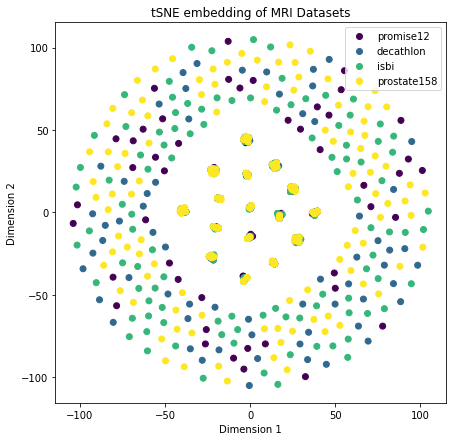

In [63]:
# x = torch.randn(10,2)
# y = torch.randint(0,3,(10,))
# print(y)
from matplotlib.colors import ListedColormap
# base_colors = ['b', 'g', 'r', 'c', 'm', 'y']
# colors = base_colors[:len(np.unique(y))]
# print(colors)
color_labels = (labels_map_reverse[i] for i in range(len(labels_map)))
# Plot the low dimensional embeeding obtained with t-SNE
plt.figure(figsize=(7,7))
scatter  = plt.scatter(x = el_repr_embed[:,0], y=el_repr_embed[:,1], c=el_labels)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(handles=scatter.legend_elements()[0], labels=color_labels)
plt.title('tSNE embedding of MRI Datasets')
plt.show()


In [ ]:
plt.figure(figsize=(8*2,8*2))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(latent_representation[15, i], cmap='gray')
    plt.axis('off')
    plt.title(f'{i}')
plt.suptitle(f'Latent represenation of 5')
plt.show()

In [ ]:
latent_reprs = []
for i, imgs in enumerate(multi_domain_train_loader,1):
    imgs = rearrange(imgs, 'b c h w d -> (b d) c h w')
    latent_reprs.append(model(imgs))
    if i == 5:
        break
    
latent_reprs = torch.stack(latent_reprs)
print(f"Latent repr shape : {latent_reprs.shape}")